# Fine-Tuning T5-Small on a Single GPU

Fine-tuning large language models (LLMs) almost always requires multiple GPUs to be practical (or possible at all). But if you're relatively new to deep learning, or you've only trained models on single GPUs before, making the jump to distributed training on multiple GPUs and multiple nodes can be extremely challenging and more than a little frustrating.

The goal of this project is to start small and gradually add complexity. So we're not going to start with a "large language model" at all. We're starting with a very small model called [t5-small](https://huggingface.co/t5-small). Why start with a small model if we want to train considerably larger models?
- Learning about model fine-tuning is a lot less frustrating if you start from a place of less complexity and are able to get results quickly!
- When we get to the point of training larger models on distributed systems, we're going to spend a lot of time and energy on *how* to distribute the model, data, etc., across that system. Starting smaller lets us spend some time at the beginning focusing on the training metrics that directly relate to model performance rather than the complexity involved with distributed training. Eventually we will need both, but there's no reason to try to digest all of it all at once!
- Starting small and then scaling up will give us a solid intuition of how, when, and why to use the various tools and techniques for training larger models or for using more compute resources to train models faster.

## Fine-Tuning t5-small
Our goals in this notebook are simple. We want to fine-tune the `t5-small` model and verify that its behavior has changed as a result of our fine-tuning.

The [t5 (text-to-text transfer transformer) family of models](https://blog.research.google/2020/02/exploring-transfer-learning-with-t5.html) was developed by Google Research. It was presented as an advancement over BERT-style models which could output only a class label or a span of the input. t5 allows the same model, loss, and hyperparameters to be used for *any* nlp task. t5 differs from GPT models because it is an encoder-decoder model, while GPT models are decoder-only models.

t5-small is a 60 million parameter model. This is *small*: the smallest version of GPT2 has more than twice as many parameters (124M); llama2-7b, one of the most commonly-used models at the time of writing, has more than 116 times as many parameters (7B, hence the name). What does this mean for us? Parameter count strongly impacts the amount of memory required to train a model. Eleuther's [Transformer Math blog post](https://blog.eleuther.ai/transformer-math/#training) has a great overview of the memory costs associated with training models of different sizes. We'll get into this in more detail in a later notebook.

## A few things to keep in mind
If you're looking for a set of absolute best practices for how to train particular models, this isn't the place to find them (though I will link them when I come across them, and will try to make improvements where I can, as long as they don't come at the cost of extra complexity!). The goal is to develop a high-level understanding and intuition on model training and fine-tuning, so you can fairly quickly get to something that *works* and then iterate to make it work *better*.

## Compute used in this example
I am using a `g4dn.4xlarge` AWS ec2 instance, which has a single T4 GPU with 16GB VRAM.

## 1. Get the model and generate some predictions
Before training the model, it helps to have some sense of its base behavior. Let's take a look. See appendix C of the [t5 paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf) for examples of how to format inputs for various tasks.

We will be using the [transformers](https://huggingface.co/docs/transformers/index) library to load and run the model.

In [1]:
# Some Environment Setup
OUTPUT_DIR = "output"
LOG_DIR = "logs"
CACHE_DIR = "cache"

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Sample text
input_text = (
    "question: What is the deepspeed license?  context: DeepSpeed "
    "is an open source deep learning optimization library for PyTorch. "
    "The library is designed to reduce computing power and memory use "
    "and to train large distributed models with better parallelism on "
    "existing computer hardware. DeepSpeed is optimized for low latency, "
    "high throughput training. It includes the Zero Redundancy Optimizer "
    "(ZeRO) for training models with 1 trillion or more parameters. "
    "Features include mixed precision training, single-GPU, multi-GPU, "
    "and multi-node training as well as custom model parallelism. The "
    "DeepSpeed source code is licensed under MIT License and available on GitHub."
)

# Another task you could try:
# input_text = "Translate English to German: The house is wonderful."

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

MIT License


If you understand what the above code did, great! Feel free to move on. If not, also great! Here's some suggested reading.
- Learn about loading models with the Transformers library [here](https://huggingface.co/learn/nlp-course/chapter2/3). The whole course is well worth the time and will give a lot of useful background for this fine-tuning guide.
- Learn about tokenizers from Hugging Face [here](https://huggingface.co/docs/transformers/main/en/preprocessing).
- We'll talk a lot more about GPUs later, but the `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` line checks whether the system has a CUDA-enabled GPU and the necessary software to use it. If yes, it will use the GPU; otherwise, it will fall back to CPU. This is a common pattern when training models with PyTorch, which is the underlying framework used by the transformers library in the above code.

## 2. Pick a Fine-Tuning Task

We want to train the model to do something it's not already capable of. Let's see if we can get it to distinguish between a few different programming languages. Is it able to do this now?

In [3]:
input_text = "question: what programming languauage is this?  code: `df <- read.csv('data.csv'); summary(df)`"

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

df - read.csv('data.csv'


Doesn't look like it! Based on the T5 paper, I couldn't identify a prompt that would elicit this behavior. Furthermore, When T5 was trained, code examples were apparently explicitly excluded. So let's see if we can add this capability.

> Some pages inadvertently contained code. Since the curly bracket “{” appears in many programming languages (such as Javascript, widely used on the web) but not in natural text, we removed any pages that contained a curly bracket.

We will use the [tiny-codes](https://huggingface.co/datasets/nampdn-ai/tiny-codes) dataset, which includes code snippets along with their corresponding language, as training data. Let's pull down the dataset and do a quick exploratory analysis. Then we will have to do some cleaning and prep to make the code usable for our purposes.

## 3. Get and Explore the Data

You will need to create a hugging face account and log in using the `notebook_login()` interface below in order to download the [tiny-codes dataset](https://huggingface.co/datasets/nampdn-ai/tiny-codes).

In [4]:
from datasets import load_dataset
from huggingface_hub import notebook_login

# Login
notebook_login()

In [5]:
# Load the dataset
tinycodes = load_dataset("nampdn-ai/tiny-codes", cache_dir=CACHE_DIR)

Now let's see what languages are included and how many examples of each are in the dataset

programming_language
Rust                         136961
Ruby                         136824
JavaScript                   131014
Julia                        129402
Python                       129063
TypeScript                   128653
Go                           126016
C#                           125478
Java                         123994
Bash                         122804
C++                          120813
Neo4j database and Cypher    117589
relation database and SQL    103698
Name: count, dtype: int64


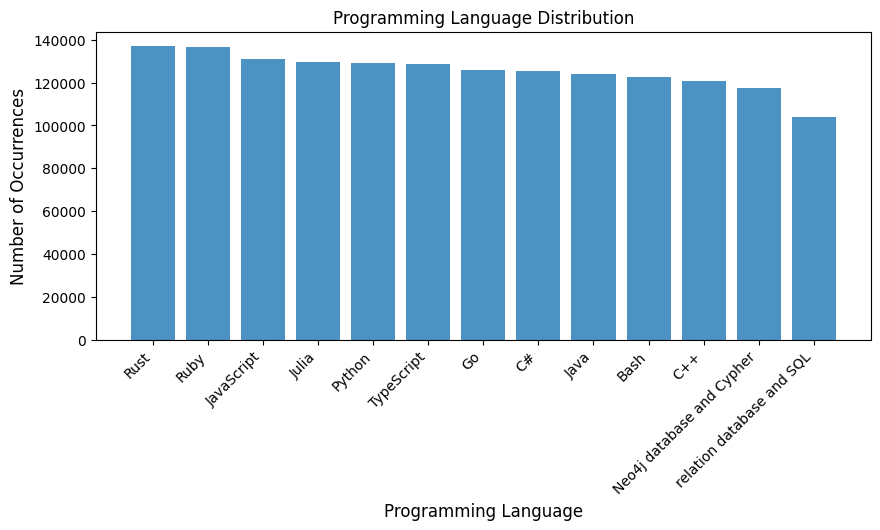

In [6]:
import matplotlib.pyplot as plt


# Get the counts of the programming_language column
language_counts = tinycodes["train"].to_pandas()["programming_language"].value_counts()

# Print the counts
print(language_counts)

plt.figure(figsize=(10, 4))
plt.bar(language_counts.index, language_counts.values, alpha=0.8)
plt.title("Programming Language Distribution")
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xlabel("Programming Language", fontsize=12)
plt.xticks(
    rotation=45, ha="right"
)  # Angle the x-axis labels to 45 degrees and align them to the right
plt.show()

There are no major imbalances and each of these languages has plenty of examples, so we're not going to do any rebalancing. Now let's take a look at what a given example looks like.

In [7]:
tinycodes["train"][3]

{'prompt': 'Develop a C# program snippet to Update Low Online Shopping: Product Availability for Analysis for Experts. Incorporate if/else or switch/case statements to handle various cases related to the Privacy. Dry-run, ensure your control flow logic is clear and well-commented.',
 'main_topic': 'Online Shopping',
 'subtopic': 'Product Availability',
 'adjective': 'Low',
 'action_verb': 'Update',
 'scenario': 'for Analysis',
 'target_audience': 'Experts',
 'programming_language': 'C#',
 'common_sense_topic': 'Privacy',
 'idx': 780696,
 'response': 'Here\'s some sample code that demonstrates how to update low online shopping product availability for analysis by experts while incorporating `if`/`else` or `switch`/`case` statements to handle different privacy scenarios:\n```c#\n// Define variables\nstring customerName = "John Doe";\nbool isMinor = false;\nDateTime birthDate = new DateTime(1980, 2, 5);\n\n// Check whether customer is underage based on their date of birth\nif (birthDate >

Given our goal of creating a language classifier, we only need the `programming_language` field and the `response`. We will also need to transform the response, extracting only the code between the backticks (omitting the language name).

In [8]:
import datasets


def preprocess_tinycodes(tinycodes: datasets.DatasetDict):
    tinycodes_subset = tinycodes["train"].to_pandas()[
        ["idx", "programming_language", "response"]
    ]
    # Extract code from response
    tinycodes_subset["code"] = tinycodes_subset["response"].str.extract(
        r"```[a-zA-Z+#]*\s+([\s\S]*?)```", expand=False
    )
    return tinycodes_subset

In [9]:
data_test = preprocess_tinycodes(tinycodes)
data_test

,idx,programming_language,response,code
0,1230929,Python,Here is python code which determines high snee...,def determine_high_sneeze_cough_etiquette(isol...
1,1109988,Rust,Here is a possible implementation of such a fu...,// Define a function called display_extreme_se...
2,1881323,Ruby,Here’s some sample ruby code which implements ...,NaN
3,780696,C#,Here's some sample code that demonstrates how ...,"// Define variables\nstring customerName = ""Jo..."
4,131131,Julia,Here is a possible implementation of this func...,NaN
...,...,...,...,...
1632304,1117266,Java,Here is a possible implementation of this requ...,NaN
1632305,1042904,relation database and SQL,Here is a sample relational database schema an...,CREATE TABLE IF NOT EXISTS `user` (\n `id...
1632306,804392,Go,Here is a sample implementation of the functio...,NaN
1632307,1338433,C#,Here is some sample code written in C#:\n\n ...,NaN


You'll notice that this is far from perfect: many examples were not captured by this regex match. Let's investigate.

In [10]:
import pandas as pd

# Calculate the percentage of NA for each programming language in data_test
na_percent = data_test.groupby("programming_language")["code"].apply(
    lambda x: x.isna().mean() * 100
)

# Display the percentage in a dataframe
na_percent_df = pd.DataFrame(na_percent)
na_percent_df

,code
programming_language,
Bash,18.923651
C#,20.937535
C++,44.289108
Go,42.364462
Java,40.571318
JavaScript,17.117255
Julia,22.030571
Neo4j database and Cypher,53.198854
Python,13.140869


We would generally spend a lot more time iterating on the data and trying to capture code from a much greater proportion of examples. However, in this case, we're just going to subset to those languages where less than 25% of examples are NA and proceed with the fine tuning. Let's update accordingly.

In [ ]:
import numpy as np


def extract_code_from_tinycodes(
    tinycodes: datasets.DatasetDict, train_frac=0.7, valid_frac=0.2
):
    # Subset languages to Bash, C#, JavaScript, Julia, Python, Rust, TypeScript
    languages = ["Bash", "C#", "JavaScript", "Julia", "Python", "Rust", "TypeScript"]
    tinycodes_subset = tinycodes["train"].to_pandas()[
        ["idx", "programming_language", "response"]
    ]
    tinycodes_subset = tinycodes_subset[
        tinycodes_subset["programming_language"].isin(languages)
    ]
    # Extract code from response
    tinycodes_subset["code"] = tinycodes_subset["response"].str.extract(
        r"```[a-zA-Z+#]*\s+([\s\S]*?)```", expand=False
    )
    # Drop rows with missing code
    tinycodes_subset = tinycodes_subset.dropna(subset=["code"])

    # Shuffle the data
    tinycodes_subset = tinycodes_subset.sample(frac=1, random_state=42)
    # Split the data into train, valid, and test sets
    train, valid, test = np.split(
        tinycodes_subset,
        [
            int(train_frac * len(tinycodes_subset)),
            int((train_frac + valid_frac) * len(tinycodes_subset)),
        ],
    )
    # Convert the pandas dataframes back to DatasetDict
    tinycodes_subset = datasets.DatasetDict(
        {
            "train": datasets.Dataset.from_pandas(train),
            "valid": datasets.Dataset.from_pandas(valid),
            "test": datasets.Dataset.from_pandas(test),
        }
    )
    return tinycodes_subset

: 

In [ ]:
tinycodes_subset = extract_code_from_tinycodes(tinycodes)
tinycodes_subset

In [ ]:
# count number of each programming language
tinycodes_subset["train"].to_pandas()["programming_language"].value_counts()


We still have a reasonably balanced training set, with between 69,000 and 92,000 examples of each language. This is likely considerably more than we need. Let's start with 10,000 examples of each language and see how far that gets us. Note that this is a fairly arbitrary number of examples, and we would spend some time calibrating the size of the training set in a real-world setting.

In [ ]:
train_sub = (
    tinycodes_subset["train"]
    .to_pandas()
    .groupby("programming_language")
    .apply(lambda x: x.sample(n=10000, random_state=42))
    .reset_index(drop=True)
)
tinycodes_subset["train"] = datasets.Dataset.from_pandas(train_sub)

valid_sub = (
    tinycodes_subset["valid"]
    .to_pandas()
    .groupby("programming_language")
    .apply(lambda x: x.sample(n=10000, random_state=42))
    .reset_index(drop=True)
)
tinycodes_subset["valid"] = datasets.Dataset.from_pandas(valid_sub)

test_sub = (
    tinycodes_subset["test"]
    .to_pandas()
    .groupby("programming_language")
    .apply(lambda x: x.sample(n=10000, random_state=42))
    .reset_index(drop=True)
)
tinycodes_subset["test"] = datasets.Dataset.from_pandas(test_sub)

### Tokenize the Dataset

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")


def preprocess_function(examples, tokenizer):
    prefix = "question: what programming language is this?  code:\n\n"
    inputs = [prefix + ex for ex in examples["code"]]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding="max_length"
    )

    labels = tokenizer(
        text_target=examples["programming_language"],
        max_length=128,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_datasets = tinycodes_subset.map(
    preprocess_function,
    fn_kwargs={"tokenizer": tokenizer},
    batched=True,
    batch_size=4096,
    load_from_cache_file=True,
)

## Start Training

In [ ]:
import torch
import mlflow
from transformers import Trainer, TrainingArguments, AutoModelForSeq2SeqLM

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = "t5-small"  # Or another T5 variant
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=1e4,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    logging_dir=LOG_DIR,
    learning_rate=2e-5,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

# Start training
with mlflow.start_run():
    trainer.train()


In [ ]:
import gc

del model
del tokenizer
del trainer
torch.cuda.empty_cache()
gc.collect()

## Inference with our fine-tuned model

Before we get too far, there are a few important things to point out here:
- The choice of training hyperparameters was more-or-less arbitrary. In a real-world scenario, we would do a lot more experimentation with e.g. batch size, regularization, etc.
- Similarily, the data mix was chosen for expediency, not for suitability for the current task. If I had to venture a guess before seeing any results, I would guess that the model learned some language-identification shortcuts such as associating `def` with python or `<-` with R.

The point here was to show that we can, in fact, fine-tune the model in a way that meaningfully changes its behavior.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import re

# Load latest model checkpoint
# List all subdirectories in OUTPUT_DIR
subdirs = next(os.walk(OUTPUT_DIR))[1]

# Filter out directories that match the checkpoint pattern
checkpoint_dirs = [d for d in subdirs if re.match(r"checkpoint-\d+", d)]

# Find the latest checkpoint (highest number)
latest_checkpoint = max(checkpoint_dirs, key=lambda d: int(d.split("-")[-1]))

# Complete path to the latest checkpoint
latest_checkpoint_path = os.path.join(OUTPUT_DIR, latest_checkpoint)

# Load model from the latest checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(latest_checkpoint_path)

# Load tokenizer and model from the latest checkpoint
tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

input_texts = [
    "question: what programming language is this?  code: def add_a_b(a, b): return a + b",  # Python
    'question: what programming language is this?  code: public class HelloWorld { public static void Main() { Console.WriteLine("Hello, World!"); } }',  # C#
    'question: what programming language is this?  code: #include <iostream> int main() { std::cout << "Hello, World!" << std::endl; return 0; }',  # C++
    'question: what programming language is this?  code: println("Hello, World!")',  # Julia
    'question: what programming language is this?  code: echo "Hello, World!"',  # Bash
    'question: what programming language is this?  code: fn main() { println!("Hello, World!"); }',  # Rust
]

# Tokenize and encode the batch of input texts
input_ids = tokenizer.batch_encode_plus(
    input_texts, padding=True, return_tensors="pt", truncation=True
).to(device)

# Generate responses for the batch
output_ids = model.generate(input_ids["input_ids"], max_new_tokens=20)

# Decode and print the output texts
for i, output_id in enumerate(output_ids):
    output_text = tokenizer.decode(output_id, skip_special_tokens=True)
    print(f"Input: {input_texts[i]}")
    print(f"Output: {output_text}\n")


It's not perfect, but it got a few of them correct and it is able to respond with valid answers in the expected format. It could not do this previously. Improving these results would likely require us to obtain more varied data. I suspect very short examples like this, for example, were not actually included in the training data and might present a bit of a challenge given that there are fewer syntactic patterns that could be used to distinguish the languages in these simple "hello, world" scripts.

In [ ]:
input_text = (
    "question: What is the deepspeed license?  context: DeepSpeed "
    "is an open source deep learning optimization library for PyTorch. "
    "The library is designed to reduce computing power and memory use "
    "and to train large distributed models with better parallelism on "
    "existing computer hardware. DeepSpeed is optimized for low latency, "
    "high throughput training. It includes the Zero Redundancy Optimizer "
    "(ZeRO) for training models with 1 trillion or more parameters. "
    "Features include mixed precision training, single-GPU, multi-GPU, "
    "and multi-node training as well as custom model parallelism. The "
    "DeepSpeed source code is licensed under MIT License and available on GitHub."
)

# Encode and generate response
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
output_ids = model.generate(input_ids, max_new_tokens=20)[0]

# Decode and print the output text
output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(output_text)

Note that whether this worked depended on the training data used. When I trained for three epochs on all of the trainin examples in the chosen subset of languages, it was no longer able to get the correct answer. However, it was able to answer correctly when I trained on only 10,000 examples for three epochs.

This highlights something really important: fine-tuning on new knowledge or new tasks can make the model "forget" its prior training. To get around this, we need to be thoughtful about how much new data we use, how long we train for, how we evaluate the fine-tuned model, and what mixture of data we use for fine-tuning.

## Try some Experiments

Model training remains an empirical practice: there's no single set of best practices that will always yield the best results. Constant experimentation and measurement are key. Get in the habit of trying different things and seeing what works. Before moving on to the next model, I suggest trying out at least three different variations of the above training run. I focused on the data in my experimentation, but you can try anything you'd like.

My experiments:
- train on all available training data for the chosen subset of languages for three epochs
- train on 10k examples of each language for three epochs
- train on 30k examples of each language for one epoch

## Conclusion

In this example, we fine-tuned `t5-small` on a new task. The basic process was:
- Pick a model and task
- Pick a dataset
- Process the dataset
- Train the model on the processed dataset

This omits plenty of important steps we'll get further into in future notebooks. For example:
- tuning hyperparameters
- thoroughly evaluating the results
- tuning training speed/efficiency
- monitoring the training loop (we did track the experiment with MLflow but did not configure it in any way for our specific usage)

We will get into each of these in future examples.